## Credit card default analysis

In this analysis, we will check the influence of certain factors on the loan default.

In [1]:
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.stats.multitest as smm
from statsmodels.stats.weightstats import *
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.proportion import proportion_confint
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
credits = pd.read_csv('credit_card_default_analysis.csv')
credits.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Information about data:
* LIMIT_BAL: credit limit
* SEX: client's sex (1 = male, 2 = female)
* EDUCATION: education (0 = phd, 1 = master; 2 = bachelor; 3 = school graduate; 4 = primary education; 5 = other; 6 = not information ).
* MARRIAGE: (0 = refuse to answer; 1 = married; 2 = single; 3 = not information).
* AGE: age in years
* PAY_0 - PAY_6 : History of payments. PAY_6 - payment in april, ... Pay_0 - payment in september. Payment = (0 = on time, 1= 1 month delay, 2=2 month delay ...)
* BILL_AMT1 - BILL_AMT6: debt, BILL_AMT6 - far april, BILL_AMT1 - for september
* PAY_AMT1 - PAY_AMT6: amount paid in PAY_AMT6 - april, ..., PAY_AMT1 - september
* default - default indicator (1 = default, 0 = not default)

In [3]:
credits.default.value_counts()

0    23364
1     6636
Name: default, dtype: int64

1. Firstly, let's look at variable **LIMIT_BAL** - the size of the credit limit and check the hypotheses about the equality of the median values of the credit limit and the equality of distributions.

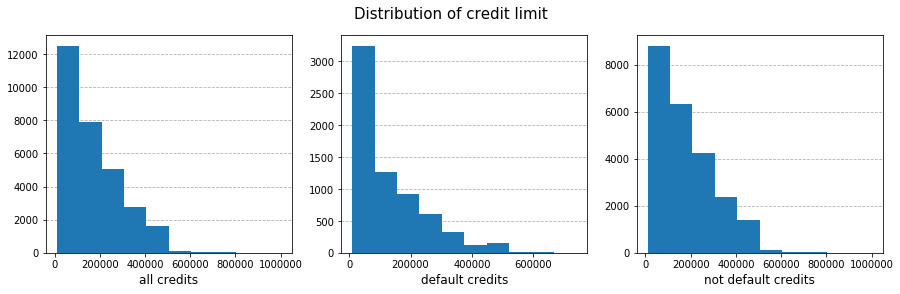

In [4]:
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
ax1.yaxis.grid(linestyle='--')
ax1.set_axisbelow(True)
ax1.hist(credits.LIMIT_BAL)
plt.suptitle('Distribution of credit limit', fontsize=15)
ax1.set_xlabel('all credits', fontsize=12)
ax2.yaxis.grid(linestyle='--')
ax2.set_axisbelow(True)
ax2.hist(credits[credits.default == 1].LIMIT_BAL)
ax2.set_xlabel('default credits', fontsize=12)
ax3.yaxis.grid(linestyle='--')
ax3.set_axisbelow(True)
ax3.hist(credits[credits.default == 0].LIMIT_BAL)
ax3.set_xlabel('not default credits', fontsize=12)
plt.show()

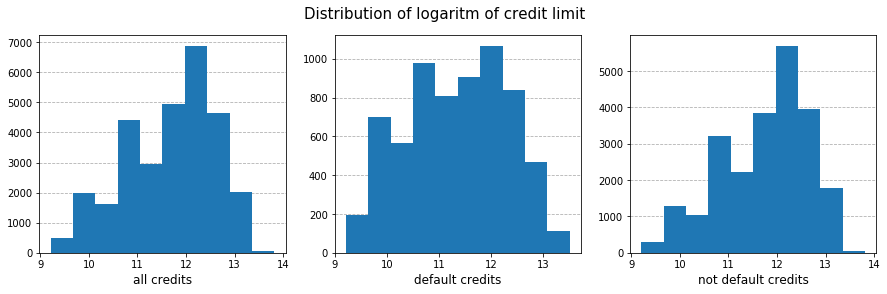

In [5]:
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
ax1.yaxis.grid(linestyle='--')
ax1.set_axisbelow(True)
ax1.hist(log(credits.LIMIT_BAL))
plt.suptitle('Distribution of logaritm of credit limit', fontsize=15)
ax1.set_xlabel('all credits', fontsize=12)
ax2.yaxis.grid(linestyle='--')
ax2.set_axisbelow(True)
ax2.hist(log(credits[credits.default == 1].LIMIT_BAL))
ax2.set_xlabel('default credits', fontsize=12)
ax3.yaxis.grid(linestyle='--')
ax3.set_axisbelow(True)
ax3.hist(log(credits[credits.default == 0].LIMIT_BAL))
ax3.set_xlabel('not default credits', fontsize=12)
plt.show()

### Hypothesis about the equality of the median values of the credit limit and the equality of distributions 

H0: mean values of credit limit for default and non-default credits are equal

H1: mean values are not equal

In [6]:
limits_default = credits[credits.default == 1].LIMIT_BAL
limits_not_default = credits[credits.default == 0].LIMIT_BAL
sc.stats.mannwhitneyu(limits_default, limits_not_default)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

We have a very small p_value, which means we can reject the null hypothesis in favor of the alternative one. Mean values are not equal.

### Confident interval for median

Using a point estimate

In [7]:
limits_default_sorted = sort(credits[credits.default == 1].LIMIT_BAL)
limits_not_default_sorted = sort(credits[credits.default == 0].LIMIT_BAL)

n_default = len(limits_default_sorted)
n_not_default = len(limits_not_default_sorted)

k_default = int(1/2*(n_default -1.96*sqrt(n_default) - 1))
k_not_default = int(1/2*(n_not_default -1.96*sqrt(n_not_default) - 1))
print('Confident interval for median of credit limits for default credits:', '[', limits_default_sorted[k_default],
     ';', limits_default_sorted[n_default - k_default + 1],']')
print('Confident interval for median of credit limits for not default credits:', '[', limits_not_default_sorted[k_not_default],
     ';', limits_not_default_sorted[n_not_default - k_not_default + 1],']')

Confident interval for median of credit limits for default credits: [ 80000 ; 90000 ]
Confident interval for median of credit limits for not default credits: [ 150000 ; 150000 ]


Using a bootstrap

In [8]:
def bootstrap(data, n = 1000):
    data = np.ravel(data)
    index = np.random.randint(data.size, size=(n, data.size))
    return data[index]

def bootci(data, stat=median, n=1000, alpha=0.05):
    boot = bootstrap(data)
    sorted_stat = np.sort(stat(boot, axis=1))
    ci = (sorted_stat[np.round(n*alpha/2).astype(int)], 
              sorted_stat[np.round(n*(1-alpha/2)).astype(int)])
    return ci
        
print('Confident interval for median of credit limits for default credits:', 
      bootci(credits[credits.default == 1].LIMIT_BAL))
print('Confident interval for median of credit limits for not default credits:', 
      bootci(credits[credits.default == 0].LIMIT_BAL))

Confident interval for median of credit limits for default credits: (80000.0, 90000.0)
Confident interval for median of credit limits for not default credits: (150000.0, 150000.0)


Confidence intervals do not overlap, so we can argue that the medians are not equal.

2. **SEX**: Let's test the hypothesis that the gender composition of the group of people who returned and did not return the credit is different.

A contingency table:

In [9]:
a = credits[credits.default == 1].SEX.value_counts()[1]
c = credits[credits.default == 1].SEX.value_counts()[2]
b = credits[credits.default == 0].SEX.value_counts()[1]
d = credits[credits.default == 0].SEX.value_counts()[2]

In [10]:
tab = pd.DataFrame({'key': ['female', 'male', 'total'], 'default': [a, c, a+c], 
                    'not_default': [b, d, b+d], 'all_credits' : [a+b, c+d, a+b+c+d]})
tab

,key,default,not_default,all_credits
0,female,2873,9015,11888
1,male,3763,14349,18112
2,total,6636,23364,30000


Check the hypothesis that gender composition differs

H0: gender composition is the same

H1: gender composition is different

Construct confidence intervals for the proportion of men in these 2 samples:

In [11]:
conf_int_male_default = proportion_confint(tab.default[1], 
                                            tab.default[2],
                                            method = 'wilson')
conf_int_male_not_default = proportion_confint(tab.not_default[1], 
                                            tab.not_default[2],
                                            method = 'wilson')
print('Confidential interval for male proportion in default credits:', conf_int_male_default)
print('Confidential interval for male proportion in not default credits:', conf_int_male_not_default)

Confidential interval for male proportion in default credits: (0.5551017630282817, 0.578937581965066)
Confidential interval for male proportion in not default credits: (0.607889734030124, 0.6203726841910749)


Confidence intervals do not overlap, so the proportions of men in default and non-default credits are not the same.
We also check using the z-test for the difference of proportions.

In [12]:
p1 = float(tab.default[1]) / tab.default[2]
p2 = float(tab.not_default[1]) / tab.not_default[2]
P = float(tab.all_credits[1]) / (tab.all_credits[2])

z_stat = (p1 - p2) / np.sqrt(P * (1 - P) * (1. / tab.default[2] + 1. / tab.not_default[2]))

print('p_value:', 2 * (1 - sc.stats.norm.cdf(np.abs(z_stat))))

p_value: 4.472866521609831e-12


p_value is small, then at a significance level of 0.05, we reject the zero hypothesis in favor of the alternative one. Gender composition is different!

3. **EDUCATION**: Test the hypothesis that education does not affect whether a person will return credit.

In [13]:
r1 = credits[credits.default == 1].EDUCATION.value_counts()
r2 =  credits[credits.default == 0].EDUCATION.value_counts()

In [14]:
tab = pd.DataFrame({'key': ['phd', 'master', 'bachelor', 'school graduate', 'primary education', 'other', 'not information'], 
                    'default': [0, r1[1], r1[2], r1[3], r1[4], r1[5], r1[6]], 
                    'not_default': [r2[0], r2[1], r2[2], r2[3], r2[4], r2[5], r2[6]]})
tab['proportion of default'] = [tab.default[i]/(tab.default[i] + tab.not_default[i]) for i in range(len(tab.default))]
tab

,key,default,not_default,proportion of default
0,phd,0,14,0.000000
1,master,2036,8549,0.192348
2,bachelor,3330,10700,0.237349
3,school graduate,1237,3680,0.251576
4,primary education,7,116,0.056911
5,other,18,262,0.064286
6,not information,8,43,0.156863


Make multiple testing of hypotheses for the comparison of proportions by levels of education

In [15]:
p_values = []
for i in [0, 1, 2, 3, 4, 5, 6]:
    p1 = float(tab.default[i]) / sum(tab.default)
    p2 = float(tab.not_default[i]) / sum(tab.not_default)
    P = float(p1*sum(tab.default) + p2*sum(tab.not_default)) / (sum(tab.default) + sum(tab.not_default))
    z_stat = (p1 - p2) / np.sqrt(P * (1 - P) * (1. / tab.default[2] + 1. / tab.not_default[2]))
    p_values.append(2 * (1 - sc.stats.norm.cdf(np.abs(z_stat))))
tab['p_value'] = p_values
tab

,key,default,not_default,proportion of default,p_value
0,phd,0,14,0.000000,1.620582e-01
1,master,2036,8549,0.192348,4.603316e-10
2,bachelor,3330,10700,0.237349,9.521837e-06
3,school graduate,1237,3680,0.251576,8.343973e-05
4,primary education,7,116,0.056911,2.044648e-03
5,other,18,262,0.064286,8.371890e-06
6,not information,8,43,0.156863,4.373598e-01


Based on the results, we can say that there is a significant difference only for 2 categories - people with phd and people who have not indicated their education.

4. **MARRIAGE**: Check how the marital status is related to the default indicator

Calculate the Kramen’s coefficient for these two variables and see if there is a relation between them.

In [16]:
pd.crosstab(credits.default, credits.MARRIAGE, margins=True)

MARRIAGE,0,1,2,3,All
default,,,,,
0,49,10453,12623,239,23364
1,5,3206,3341,84,6636
All,54,13659,15964,323,30000


In [17]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = sc.stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [18]:
cramers_v(credits.default, credits.MARRIAGE)

0.03299665874336609

Relation is very weak.

5. **AGE**: Regarding two groups of people who returned and did not return credit, check the following hypotheses: a) equality of the median values of people’s ages b) equality of distributions.

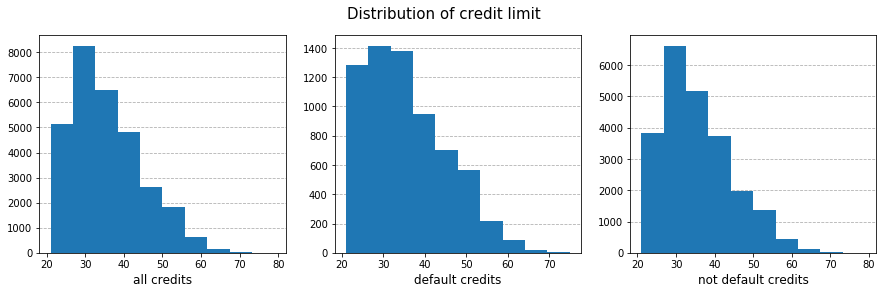

In [19]:
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
ax1.yaxis.grid(linestyle='--')
ax1.set_axisbelow(True)
ax1.hist(credits.AGE)
plt.suptitle('Distribution of credit limit', fontsize=15)
ax1.set_xlabel('all credits', fontsize=12)
ax2.yaxis.grid(linestyle='--')
ax2.set_axisbelow(True)
ax2.hist(credits[credits.default == 1].AGE)
ax2.set_xlabel('default credits', fontsize=12)
ax3.yaxis.grid(linestyle='--')
ax3.set_axisbelow(True)
ax3.hist(credits[credits.default == 0].AGE)
ax3.set_xlabel('not default credits', fontsize=12)
plt.show()

### Hipothesis about the equality of distributions

H0: mean values of age for default and non-default loans are equal
H1: mean values of age for default and non-default loans are not equal

In [20]:
age_default = credits[credits.default == 1].AGE
age_not_default = credits[credits.default == 0].AGE
sc.stats.mannwhitneyu(age_default, age_not_default)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

p_value > 0.05, we can not refuse null-hypothesis.

### Confident intervals for medians

In [21]:
print('Confident interval for median of credit limits for default credits:', 
      bootci(credits[credits.default == 1].AGE))
print('Confident interval for median of credit limits for not default credits:', 
      bootci(credits[credits.default == 0].AGE))

Confident interval for median of credit limits for default credits: (34.0, 35.0)
Confident interval for median of credit limits for not default credits: (34.0, 34.0)
